## Imports

MMDetection and our library

In [1]:
import apr
import mmdet
from mmcv import Config
import pickle

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as patches
import matplotlib.lines as lines

Load the config file from MMDetection for SSD300

In [3]:
mmdetection_configs_root = '/home/mbonnaer/github.com/mmdetection/configs'
original_mmdet_ssd_config = f'{mmdetection_configs_root}/ssd/ssd300_coco.py'

cfg = Config.fromfile(original_mmdet_ssd_config)

Redefine the anchors by using our `PreciseAnchorGenerator` that allows each individual anchor to be specified.

To get the scale and ratio of every anchor of an existing MMDetection model use our tool in `tools/convert_mmdet_config.py`

In [4]:
!python tools/convert_mmdet_config.py {original_mmdet_ssd_config}

Converting Anchor Generator of file /home/mbonnaer/github.com/mmdetection/configs/ssd/ssd300_coco.py
Converting generator of the type SSDAnchorGenerator to PreciseAnchorGenerator.
{'type': 'SSDAnchorGenerator',
 'scale_major': False,
 'input_size': 300,
 'basesize_ratio_range': (0.15, 0.9),
 'strides': [8, 16, 32, 64, 100, 300],
 'ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]]}
Old config used:
/home/mbonnaer/github.com/mmdetection/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
New config to be used:
{'_delete_': True,
 'type': 'PreciseAnchorGenerator',
 'strides': [8, 16, 32, 64, 100, 300],
 'scale_ratios': [[(0.07, 1.0), (0.1025, 1.0), (0.07, 0.5), (0.07, 2.0)],
                  [(0.15, 1.0),
                   (0.2225, 1.0),
                   (0.15, 0.5),
                   (0.15, 2.0),
                   (0.15

*The adjusted model config below is **not** compatible with the provided model checkpoint from MMDetection, the difference is in the order of anchors, we specify them in the same order as the original SSD paper which is different to the order of the MMDetection model.*

In [5]:
adjusted_model_cfg = dict(
    model=dict(
        bbox_head=dict(
            anchor_generator=dict(
                _delete_=True,
                type='PreciseAnchorGenerator',
                strides=[8, 16, 32, 64, 100, 300],
                scale_ratios=(
                    ((0.07, 1.0), (0.07, 2.0), (0.07, 0.5), (0.1024, 1.0)),
                    ((0.15, 1.0), (0.15, 2.0), (0.15, 3.0), (0.15, 0.5), (0.15, 1 / 3), (0.224, 1.0)),
                    ((0.33, 1.0), (0.33, 2.0), (0.33, 3.0), (0.33, 0.5), (0.33, 1 / 3), (0.4102, 1.0)),
                    ((0.51, 1.0), (0.51, 2.0), (0.51, 3.0), (0.51, 0.5), (0.51, 1 / 3), (0.5932, 1.0)),
                    ((0.69, 1.0), (0.69, 2.0), (0.69, 0.5), (0.7747, 1.0)),
                    ((0.87, 1.0), (0.87, 2.0), (0.87, 0.5), (0.9557, 1.0)),
                    ),
                anchor_base_size=300
            )
        )
    )
)
cfg.merge_from_dict(adjusted_model_cfg)

The required input for our anchor pruning script is a directory with a checkpoint of the model named `best_checkpoint.pth` and a single `.py` config file. So lets create that:

In [6]:
#! mkdir pruning_directory
# Download ssd_baseline.pth from https://cloud.ilabt.imec.be/index.php/s/ERxYsRMidPEgNwT
#! cp ssd_baseline.pth ./pruning_directory/best_checkpoint.pth
#! cp ./configs/ssd_baseline.py ./pruning_directory/ 

And then run our tool:

In [7]:
#! python tools/prune_anchors.py -i ./pruning_directory/ -o ./pruning_directory/pruning_results.pickle

In [8]:
with open('./pruning_directory/pruning_results.pickle', 'rb') as map_results_file:
    results = pickle.load(map_results_file)
results['pareto_front'] = list(reversed(sorted(results['pareto_front'], key=lambda k: k['mAP']))) # sort pareto front on mAP

`results` is a dictionary that consists of a list of the pareto front of anchor configurations that are optimal to prune.
Based on the mAP and the #mac operation one can choose which pruned configuration one would like to use.
Below we plot the pareto frontier of pruned configurations.

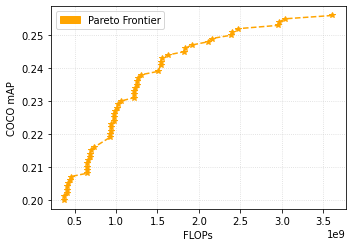

In [9]:
fig = plt.figure(1, figsize=(5,3.54331))
ax = plt.subplot(111)
ax.set_xlabel('FLOPs')
ax.set_ylabel('COCO mAP')

ax.plot([node['macs'] for node in results['pareto_front']], [node['mAP'] for node in results['pareto_front']],
       linestyle='--', marker='*', color='orange', markerfacecolor='orange', markersize=6)
legend_patches =  [patches.Patch(color='orange', label='Pareto Frontier')]
ax.set_xlabel('FLOPs')
ax.set_ylabel('COCO mAP')
ax.grid(linestyle=':', alpha=0.5)
plt.legend(handles=legend_patches)
plt.tight_layout()
plt.show()

In [10]:
for node in results['pareto_front']:
    print(node['removed_anchors'], node['mAP'], node['macs'])

{5, 7, 13, 16, 17, 19, 22, 25, 26, 27, 28} 0.256 3607764480
{2, 5, 7, 13, 16, 17, 19, 22, 25, 26, 27, 28} 0.255 3042178560
{2, 5, 7, 10, 12, 13, 16, 17, 19, 22, 25, 26, 27, 28} 0.254 2963842560
{2, 5, 7, 10, 12, 13, 16, 17, 19, 20, 22, 23, 25, 26, 27, 28} 0.253 2957184000
{1, 2, 5, 7, 13, 16, 17, 19, 22, 25, 26, 27, 28} 0.252 2476592640
{1, 2, 5, 7, 10, 12, 13, 16, 17, 19, 22, 25, 26, 27, 28} 0.251 2398256640
{1, 2, 5, 7, 10, 12, 13, 16, 17, 18, 19, 20, 22, 25, 26, 27, 28} 0.25 2388464640
{1, 2, 5, 7, 8, 10, 13, 16, 17, 19, 22, 25, 26, 27, 28} 0.249 2154631680
{1, 2, 5, 7, 8, 10, 12, 13, 16, 17, 19, 20, 22, 25, 26, 27, 28} 0.248 2110567680
{1, 2, 3, 5, 7, 13, 16, 17, 19, 22, 25, 26, 27, 28} 0.247 1911006720
{1, 2, 3, 5, 7, 10, 12, 13, 16, 17, 19, 22, 25, 26, 27, 28} 0.246 1832670720
{1, 2, 3, 5, 7, 10, 12, 13, 16, 17, 18, 19, 20, 22, 25, 26, 27, 28} 0.245 1822878720
{1, 2, 3, 5, 7, 8, 13, 16, 17, 19, 22, 25, 26, 27, 28} 0.244 1628213760
{1, 2, 3, 5, 7, 8, 10, 12, 13, 16, 17, 19, 22, 25

To convert these `removed_anchors` back to a configuration you remove the anchors corresponding to the indices indicated above.
For example Configuration A from the paper corresponds with the pruned configuration with the highest accuracy and becomes:

configuration A = {5, 7, 13, 16, 17, 19, 22, 25, 26, 27, 28})

scale_ratios=(

((0.07, 1.0), (0.07, 2.0), (0.07, 0.5), (0.1024, 1.0)),

((0.15, 1.0), ~~(0.15, 2.0)~~, (0.15, 3.0), ~~(0.15, 0.5)~~, (0.15, 1 / 3), (0.224, 1.0)),

((0.33, 1.0), (0.33, 2.0), (0.33, 3.0), ~~(0.33, 0.5)~~, (0.33, 1 / 3), (0.4102, 1.0)),

(~~(0.51, 1.0), (0.51, 2.0)~~, (0.51, 3.0), ~~(0.51, 0.5)~~, (0.51, 1 / 3), (0.5932, 1.0)),

(~~(0.69, 1.0)~~, (0.69, 2.0), (0.69, 0.5), ~~(0.7747, 1.0)~~),

(~~(0.87, 1.0), (0.87, 2.0), (0.87, 0.5),~~ (0.9557, 1.0)),
),

In [11]:
adjusted_model_cfg = dict(
    model=dict(
        bbox_head=dict(
            anchor_generator=dict(
                _delete_=True,
                type='PreciseAnchorGenerator',
                strides=[8, 16, 32, 64, 100, 300],
                scale_ratios=(
                    ((0.07, 1.0), (0.07, 2.0), (0.07, 0.5), (0.1024, 1.0)),
                    ((0.15, 1.0), (0.15, 3.0), (0.15, 1/3), (0.224, 1.0)),
                    ((0.33, 1.0), (0.33, 2.0), (0.33, 3.0), (0.33, 1/3), (0.4102, 1.0)),
                    ((0.51, 3.0), (0.51, 1/3), (0.5932, 1.0)),
                    ((0.69, 2.0), (0.69, 0.5)),
                    ((0.9557, 1.0))
                    ),
                anchor_base_size=300
            )
        )
    )
)
cfg.merge_from_dict(adjusted_model_cfg)

To train these new configurations with MMDetection it is as simple as adding `import apr` to the scripts of MMDetection. Or you can use the scripts provided in our tools directory, which have done exactly that.